In [1]:
import os,sys,signal
import math

In [2]:
import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
sys.path.insert(0, '../')
sys.path.insert(0,'../GPU_tool/Installation/nnAudio/')

import musicnet

from time import time

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn

from nnAudio import Spectrogram

if torch.cuda.is_available():
    device = "cuda:0"
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = "cpu"

In [3]:
# Network Parameters
epochs = 35
train_size = 100000
test_size = 50000
epsilon = 1e-5
fs = 44100

lr = 1e-6
momentum = .95

pitch_shift = 0
jitter = 0.
num_workers = 10
sequence = 1

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100
freq_bins = 2049

regions = 1 + (window)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': True, 'worker_init_fn': worker_init}

In [4]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [5]:
result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               "Mir_Eval": [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter
result_dict['parameters']['window'] = window

# Preparing Dataset

In [6]:
start = time()
root = './data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size,sequence=sequence
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True,sequence=sequence
                             , refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Data loaded, time used = {:2.2f} seconds".format(time()-start))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

Data loaded, time used = 27.78 seconds


In [7]:
with train_set:
    for i, (x,y) in enumerate(train_loader):
        break

In [8]:
x

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

# Defining Models

In [6]:
Loss = torch.nn.BCELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [26]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Getting Mel Spectrogram on the fly
        self.n_mels = 512
        self.spec_layer = Spectrogram.MelSpectrogram(sr=22050, n_fft=4096, n_mels=self.n_mels, 
                                        hop_length=512, window='hann', center=True, 
                                        pad_mode='reflect', htk=False, fmin=0.0, fmax=None, 
                                        norm=1, trainable_mel=True, trainable_STFT=False)
        self.n_bins = freq_bins
        # Creating Layers
        self.linear = torch.nn.Linear(self.n_mels*regions, m, bias=False)
        torch.nn.init.xavier_uniform_(self.spec_layer.mel_basis)
#         torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
    def forward(self,x):
        z = self.spec_layer(x)
        z = torch.relu(z)
        y = self.linear((torch.log(z+epsilon)).view(x.data.size()[0], self.n_mels*regions))
        return torch.sigmoid(y)
    

In [27]:
model = Model()
model.to(device)

STFT filter created, time used = 0.8487 seconds
Mel filter created, time used = 0.0174 seconds


Model(
  (spec_layer): MelSpectrogram()
  (linear): Linear(in_features=16896, out_features=128, bias=False)
)

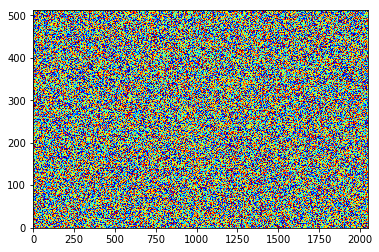

In [28]:
original_mel_basis = model.spec_layer.mel_basis.cpu().detach().numpy()
plt.imshow(original_mel_basis, aspect='auto', origin='lower', cmap='jet')

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [30]:
try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"training {i}/{len(train_loader)} batches", end = '\r')
                optimizer.zero_grad()

                # making x and y into pytorch dealable format
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data

                optimizer.step()
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())  

            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight

            # For testing
            yground = torch.Tensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(test_loader), m)

            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))

except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")

epoch	train loss	test loss	train avg	test avg	time	utime
0	13.703695	6.194629	0.051997	0.139441	37.8	11.8
1	6.934616	5.337361	0.214267	0.212550	37.6	11.7
2	6.285054	4.928243	0.268439	0.245640	38.0	11.8
3	5.926331	4.734873	0.294244	0.268405	37.8	11.7
4	5.721914	4.550333	0.308324	0.278638	37.8	11.8
5	5.571757	4.415168	0.318145	0.289668	37.8	11.7
6	5.421975	4.316083	0.327761	0.300797	37.9	11.9
7	5.325682	4.252903	0.333524	0.306389	37.8	11.8
8	5.243289	4.205085	0.338307	0.309633	37.8	11.7
9	5.175536	4.145899	0.343471	0.315789	45.3	19.3
10	5.127576	4.109644	0.348529	0.320766	87.7	29.0
11	5.050326	4.071764	0.354209	0.323476	87.6	28.3
12	4.971244	4.017298	0.357555	0.328837	84.3	28.7
13	4.959475	3.993809	0.361812	0.334535	85.2	28.4
14	4.924629	3.946050	0.362679	0.335853	86.4	29.0
15	4.884218	3.922998	0.366986	0.339086	85.4	28.9
16	4.850054	3.902785	0.371248	0.342498	86.9	28.6
17	4.810475	3.879885	0.371097	0.343645	85.0	28.3
18	4.786377	3.843423	0.374449	0.345075	86.3	28.7
19	4.749039	3.821176	

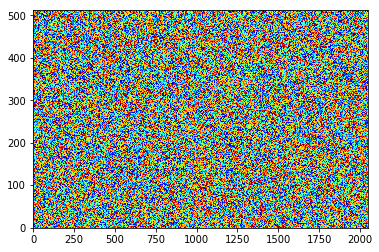

In [31]:
trained_mel_basis = model.spec_layer.mel_basis.cpu().detach().numpy()
plt.imshow(trained_mel_basis, aspect='auto', origin='lower', cmap='jet')

In [36]:
model.linear.weight.shape

torch.Size([128, 16896])

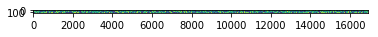

In [35]:
plt.imshow(model.linear.weight.cpu().detach().numpy())

In [ ]:
plt.plot(original_wsin[50][0])

array([-2.98885483e-04, -3.17253784e-04, -3.04975052e-04, ...,
       -1.32863293e-04, -1.09403416e-04, -9.36876531e-05], dtype=float32)

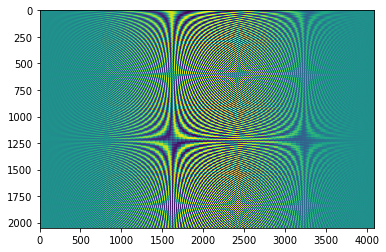

In [28]:
plt.imshow(model.STFT_layer.wsin.cpu().detach().numpy().reshape(2049,4096), aspect='auto')

In [16]:
mel_layer = Spectrogram.MelSpectrogram(sr=44100, fmin=55, fmax=6000)
STFT_layer = Spectrogram.STFT(sr=44100, n_fft=2048, fmin=50, fmax=6000, freq_scale='log', pad_mode='constant')

STFT filter created, time used = 0.2024 seconds
Mel filter created, time used = 0.0031 seconds
sampling rate = 44100. Please make sure the sampling rate is correct in order to get a valid freq range
STFT kernels created, time used = 0.1919 seconds


In [17]:
mel_layer(x)[0].cpu().numpy().shape

(128, 33)

Text(0.5, 1.0, 'Melspectrogram')

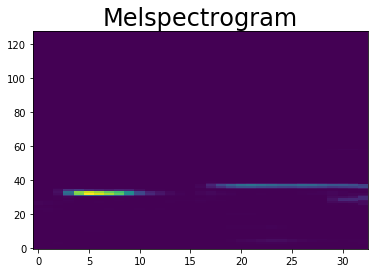

In [18]:
plt.imshow(mel_layer(x)[0].cpu().numpy(), aspect='auto', origin='lower')
plt.title("Melspectrogram", size=24)

Text(0.5, 1.0, 'STFT Log')

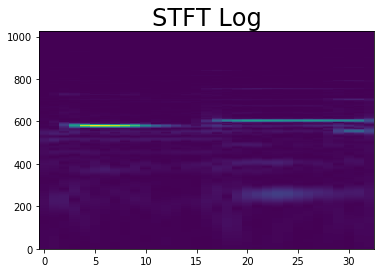

In [19]:
plt.imshow(STFT_layer(x)[0].cpu().numpy(), aspect='auto', origin='lower')
plt.title("STFT Log", size=24)

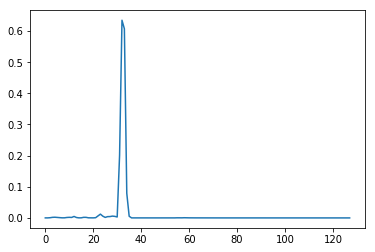

In [20]:
plt.plot(mel_layer(x)[0].cpu().numpy()[:,10])

# CQT

In [21]:
from librosa import cqt

In [22]:
lib_result = abs(cqt(x[0].cpu().numpy(), sr=44100, fmin=55, n_bins=84*4, bins_per_octave=48, pad_mode='constant'))

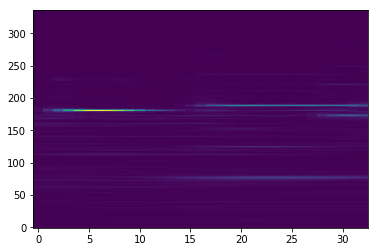

In [23]:
plt.imshow(lib_result, aspect='auto', origin='lower')

In [24]:
torch_result = model.cqt_layer(x)[0].cpu().numpy()
plt.imshow(torch_result, aspect='auto', origin='lower')

AttributeError: 'Model' object has no attribute 'cqt_layer'

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(lib_result[:, 10])
ax[1].plot(torch_result[:, 10])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
        yhat = torch.Tensor(batch_size*len(train_loader), m)
        avgp, loss_e = 0.,0
        t = time()
        for i, (x,y) in enumerate(train_loader):
            x = x.to(device)
            break
except:
    pass